In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import chi2, SelectKBest
# Cargar los datos
data = pd.read_csv('WineQT.csv')

# Mostrar las primeras filas del DataFrame
data.head()



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [3]:
# Transformar la variable objetivo en binaria
data['quality_binary'] = (data['quality'] >= 6).astype(int)

# Mostrar las primeras filas para verificar la transformación
data[['quality', 'quality_binary']].head()
# Ver la distribución de los valores en 'quality_binary'
distribution = data['quality_binary'].value_counts()
print(distribution)



quality_binary
1    621
0    522
Name: count, dtype: int64


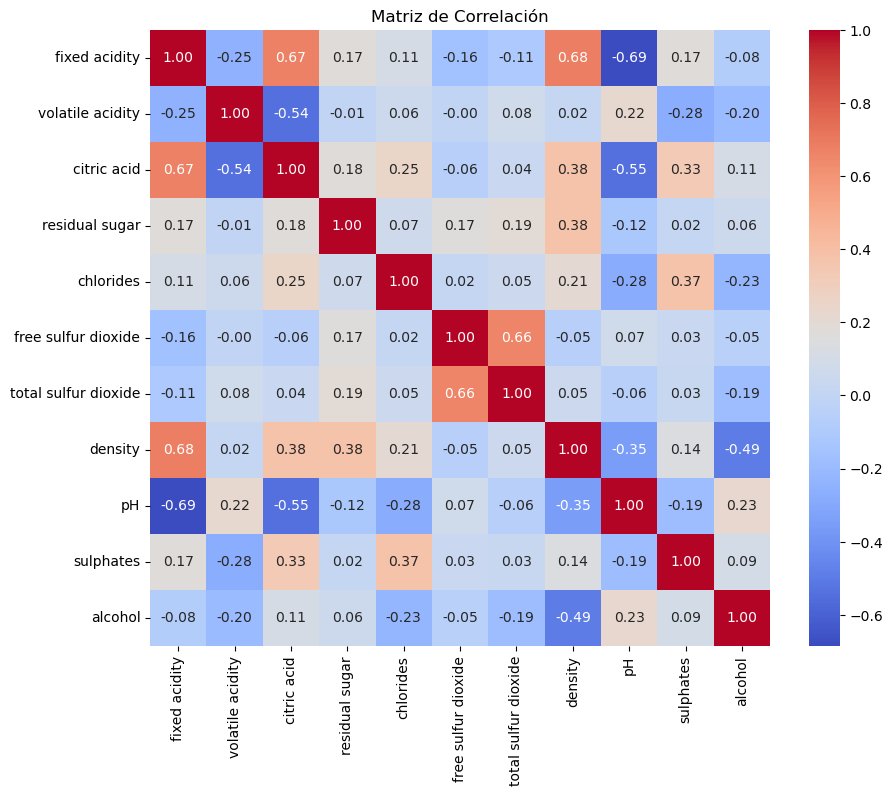

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


features = data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
                 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]

# Calcular la correlación entre características
corr_matrix = features.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


In [5]:
import pandas as pd

# Definir la función para eliminar outliers usando IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Lista de columnas relevantes para verificar outliers
columns_to_check = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
                     'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# Eliminar outliers en todas las columnas relevantes
for column in columns_to_check:
    data = remove_outliers_iqr(data, column)

# Mostrar las primeras filas del DataFrame después de eliminar outliers
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id,quality_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4,0


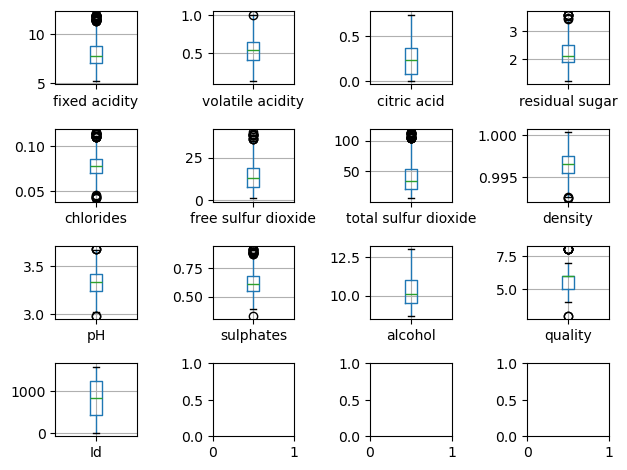

In [6]:
fig, axes = plt.subplots(4,4) 


for i,el in enumerate(list(data.columns.values)[:-1]):
    a = data.boxplot(el, ax=axes.flatten()[i], figsize= [20,20],grid=True,)


plt.tight_layout() 

plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Separar características (X) y variable objetivo (y)
X = data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
          'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
y = data['quality_binary'] 

# Dividir en conjunto de entrenamiento (70%) y prueba/validación (30%) con estratificación
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Dividir el conjunto de prueba/validación en prueba (50%) y validación (50%) con estratificación
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Mostrar el tamaño de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")


Tamaño del conjunto de entrenamiento: 557
Tamaño del conjunto de validación: 120
Tamaño del conjunto de prueba: 120


In [9]:
# Selección de características utilizando Chi-Cuadrado
chi2_selector = SelectKBest(chi2, k=7)
X_train_best = chi2_selector.fit_transform(X_train, y_train)
X_val_best = chi2_selector.transform(X_val)
X_test_best = chi2_selector.transform(X_test)
 # Escalar los datos
scaler = StandardScaler()
X_train_best_scaled = scaler.fit_transform(X_train_best)
X_val_best_scaled = scaler.transform(X_val_best)
X_test_best_scaled = scaler.transform(X_test_best)

# Ver características seleccionadas
selected_features = X.columns[chi2_selector.get_support()]
print("Mejores características según Chi-Cuadrado:", selected_features.tolist())

Mejores características según Chi-Cuadrado: ['fixed acidity', 'volatile acidity', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']


Probando k = 1
Validation Accuracy for k=1: 0.6916666666666667
Test Accuracy for k=1: 0.7833333333333333
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        55
           1       0.77      0.85      0.81        65

    accuracy                           0.78       120
   macro avg       0.79      0.78      0.78       120
weighted avg       0.78      0.78      0.78       120



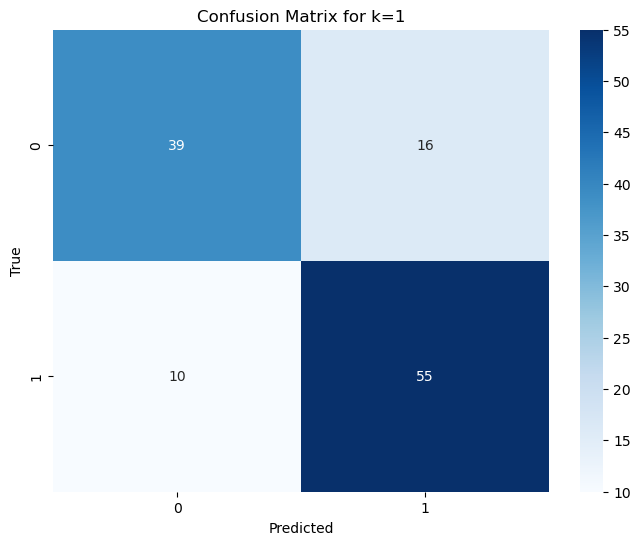

Probando k = 3
Validation Accuracy for k=3: 0.7083333333333334
Test Accuracy for k=3: 0.7583333333333333
              precision    recall  f1-score   support

           0       0.81      0.62      0.70        55
           1       0.73      0.88      0.80        65

    accuracy                           0.76       120
   macro avg       0.77      0.75      0.75       120
weighted avg       0.77      0.76      0.75       120



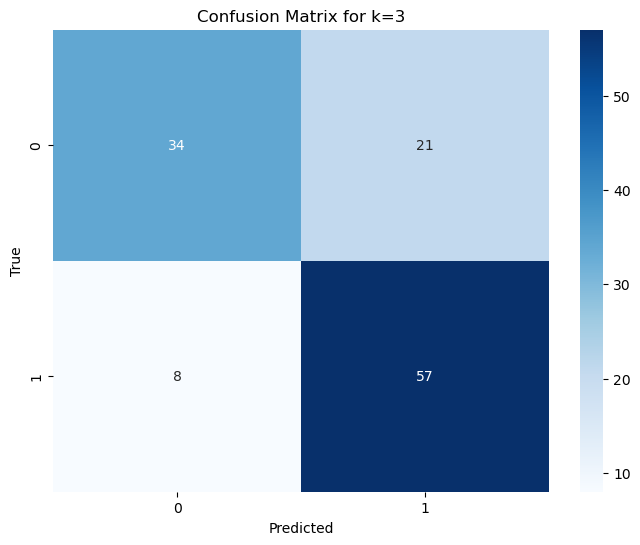

Probando k = 4
Validation Accuracy for k=4: 0.7166666666666667
Test Accuracy for k=4: 0.75
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        55
           1       0.76      0.78      0.77        65

    accuracy                           0.75       120
   macro avg       0.75      0.75      0.75       120
weighted avg       0.75      0.75      0.75       120



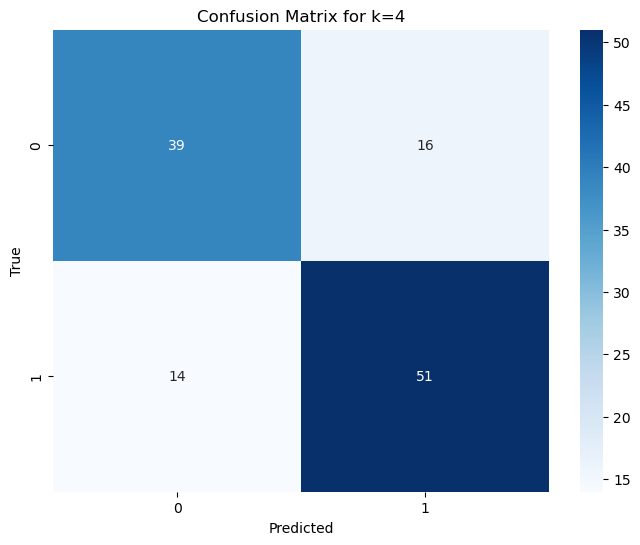

Probando k = 5
Validation Accuracy for k=5: 0.7416666666666667
Test Accuracy for k=5: 0.7583333333333333
              precision    recall  f1-score   support

           0       0.80      0.64      0.71        55
           1       0.74      0.86      0.79        65

    accuracy                           0.76       120
   macro avg       0.77      0.75      0.75       120
weighted avg       0.76      0.76      0.75       120



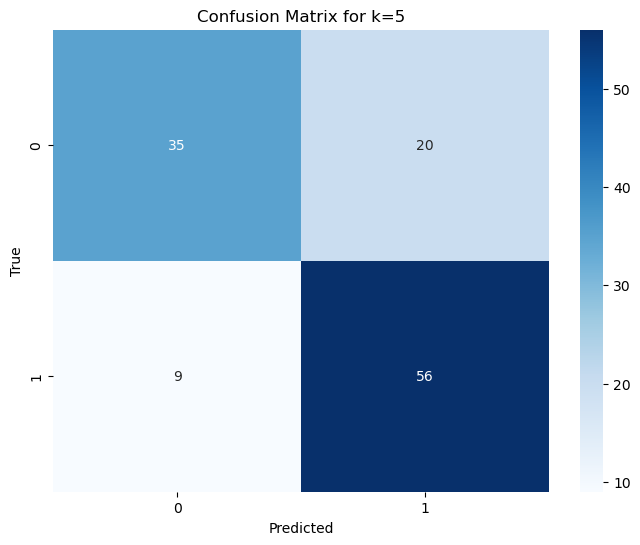

Probando k = 7
Validation Accuracy for k=7: 0.6833333333333333
Test Accuracy for k=7: 0.7416666666666667
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        55
           1       0.74      0.82      0.77        65

    accuracy                           0.74       120
   macro avg       0.74      0.73      0.74       120
weighted avg       0.74      0.74      0.74       120



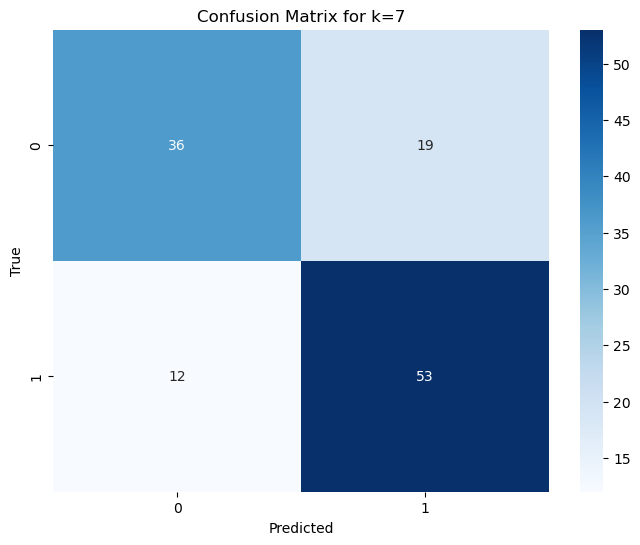

Probando k = 8
Validation Accuracy for k=8: 0.7083333333333334
Test Accuracy for k=8: 0.75
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        55
           1       0.77      0.77      0.77        65

    accuracy                           0.75       120
   macro avg       0.75      0.75      0.75       120
weighted avg       0.75      0.75      0.75       120



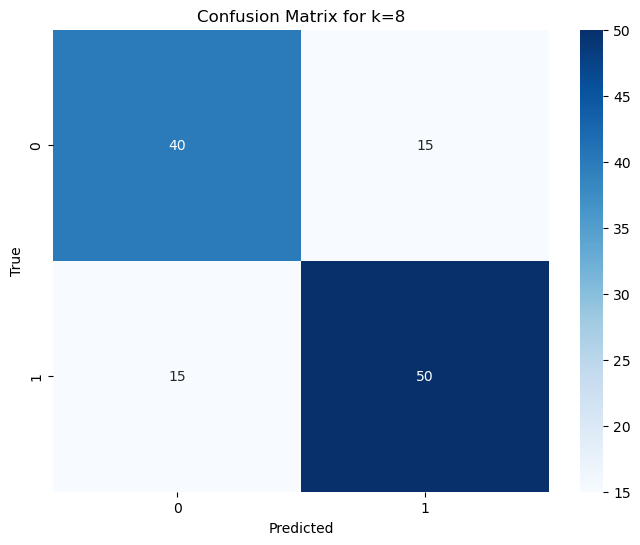

Probando k = 9
Validation Accuracy for k=9: 0.725
Test Accuracy for k=9: 0.7416666666666667
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        55
           1       0.74      0.82      0.77        65

    accuracy                           0.74       120
   macro avg       0.74      0.73      0.74       120
weighted avg       0.74      0.74      0.74       120



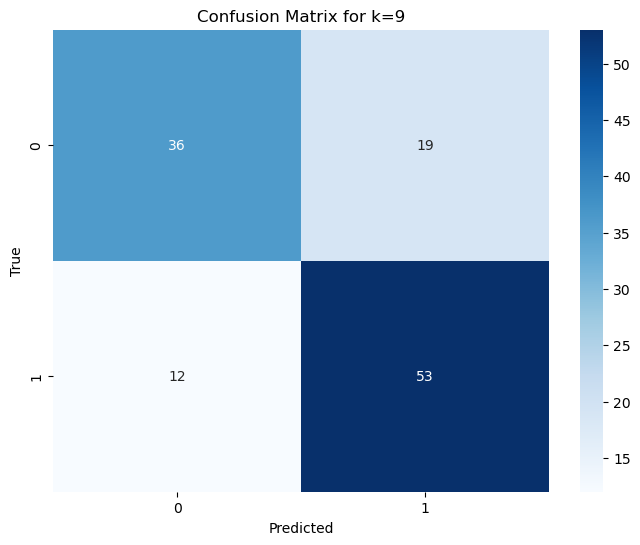

Probando k = 10
Validation Accuracy for k=10: 0.7166666666666667
Test Accuracy for k=10: 0.7333333333333333
              precision    recall  f1-score   support

           0       0.70      0.73      0.71        55
           1       0.76      0.74      0.75        65

    accuracy                           0.73       120
   macro avg       0.73      0.73      0.73       120
weighted avg       0.73      0.73      0.73       120



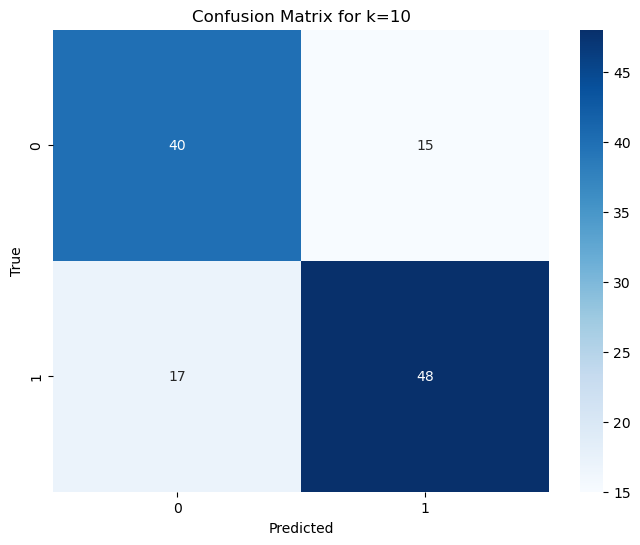

Probando k = 11
Validation Accuracy for k=11: 0.7333333333333333
Test Accuracy for k=11: 0.7583333333333333
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        55
           1       0.76      0.82      0.79        65

    accuracy                           0.76       120
   macro avg       0.76      0.75      0.75       120
weighted avg       0.76      0.76      0.76       120



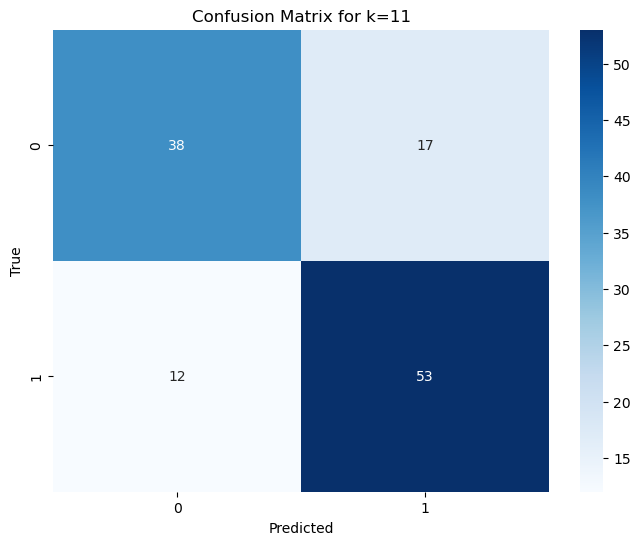

Probando k = 15
Validation Accuracy for k=15: 0.7083333333333334
Test Accuracy for k=15: 0.725
              precision    recall  f1-score   support

           0       0.74      0.62      0.67        55
           1       0.72      0.82      0.76        65

    accuracy                           0.72       120
   macro avg       0.73      0.72      0.72       120
weighted avg       0.73      0.72      0.72       120



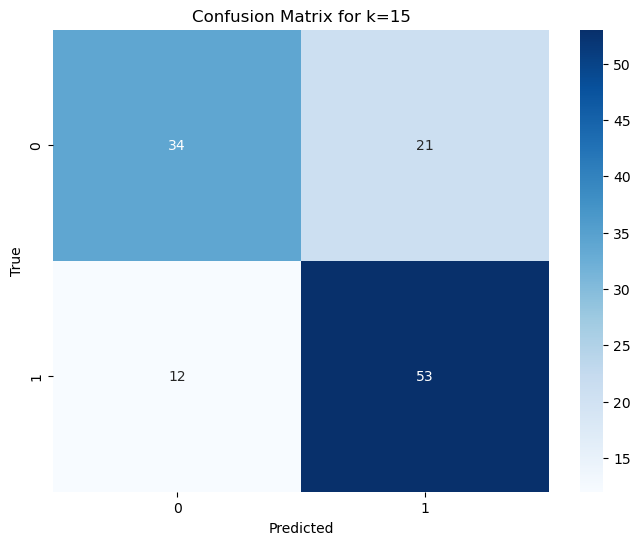

    k  Validation Accuracy  Test Accuracy
0   1             0.691667       0.783333
1   3             0.708333       0.758333
2   4             0.716667       0.750000
3   5             0.741667       0.758333
4   7             0.683333       0.741667
5   8             0.708333       0.750000
6   9             0.725000       0.741667
7  10             0.716667       0.733333
8  11             0.733333       0.758333
9  15             0.708333       0.725000


In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lista de valores de k a probar
k_values = [1,3,4,5,7,8,9,10, 11, 15]

# Almacenar los resultados
results = []

# Probar cada valor de k
for k in k_values:
    print(f"Probando k = {k}")

    # Crear el modelo con el valor actual de k
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Entrenar el modelo
    knn.fit(X_train_best_scaled, y_train)
    
    # Evaluar en el conjunto de validación
    y_val_pred = knn.predict(X_val_best_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy for k={k}: {val_accuracy}")
    
    # Evaluar en el conjunto de prueba
    y_test_pred = knn.predict(X_test_best_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy for k={k}: {test_accuracy}")
    
    # Almacenar los resultados
    results.append({
        'k': k,
        'Validation Accuracy': val_accuracy,
        'Test Accuracy': test_accuracy
    })
    
    # Mostrar informe de clasificación y matriz de confusión
    print(classification_report(y_test, y_test_pred))
    
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for k={k}')
    plt.show()

# Convertir los resultados a un DataFrame para una mejor visualización
results_df = pd.DataFrame(results)
print(results_df)
